In [112]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcess
import scipy.io as sio
import time

%matplotlib inline

In [13]:
swissrolldata = sio.loadmat('SwissRoll.mat')

In [14]:
# ground truth data
Y = np.transpose(swissrolldata['Y_data'])
# embedded data
X = np.transpose(swissrolldata['X_data'])
color = np.transpose(swissrolldata['color'])

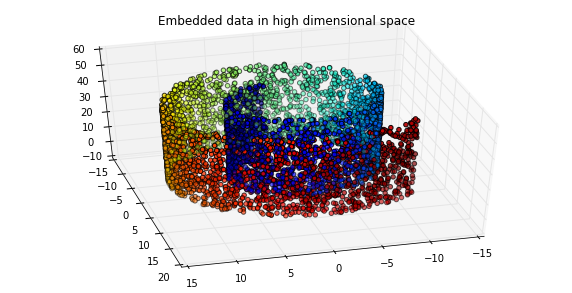

In [101]:
# plot embedded isomap
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], c=color)
ax.view_init(45,75)
ax.set_title('Embedded data in high dimensional space')

In [105]:
def lwIsomap(Xtrain,Ytrain,Xtest):
    # learn the functional mapping between reduced and embedded space
    # predict location in reduced space for rest of the points
    # We use GP to do the mapping 

    # embedded dimension 1
    gp = GaussianProcess(regr='constant',corr='squared_exponential',
                         theta0=1, nugget=0.01,random_start=100)
    y = Ytrain[:,0]
    gp.fit(Xtrain, y)
    # Make the prediction
    ytest1 = gp.predict(Xtest)
    # embedded dimension 2
    gp = GaussianProcess(regr='constant',corr='squared_exponential',
                         theta0=1, nugget=0.01, random_start=100)
    y = Ytrain[:,1]
    gp.fit(Xtrain, y)
    # Make the prediction
    ytest2 = gp.predict(Xtest)
    Ytest = np.transpose(np.vstack([ytest1,ytest2]))

    # Construct the reduced data set
    Ypred = np.zeros(Y.shape)
    Ypred[rinds[0:nsamples],:] = Ytrain
    Ypred[rinds[nsamples:],:] = Ytest
    
    return Ypred

In [98]:
def proscrutes(X,Y):
    # compute the error between Ypred and Y
    n = Y.shape[0]
    H = np.eye(n) - (1.0/n)*np.dot(np.ones([n,1]),np.transpose(np.ones([n,1])))
    Z = np.dot(np.dot(np.transpose(X),H),Y)
    U,L,V = np.linalg.svd(Z)
    A = np.dot(U,np.transpose(V))
    err = np.linalg.norm(np.dot(H,X - np.dot(Y,np.transpose(A))))
    return err

In [123]:
errormeans = []
errorstds = []
runtimes = []

for s in range(1,101):
    errors = []
    for iter in range(10):
        start = time.time()

        # select samples
        nsamples = 50*s

        rinds = np.random.permutation(X.shape[0])
        Xtrain = X[rinds[0:nsamples],:]
        Xtest = X[rinds[nsamples:],:]

        # learn the manifold
        n_neighbors = swissrolldata['K'][0][0]
        Ytrain = manifold.Isomap(n_neighbors, 2).fit_transform(Xtrain)

        # get light weight reductions
        Ypred = lwIsomap(Xtrain,Ytrain,Xtest)
        err = proscrutes(Ypred,Y)
        end = time.time()
        errors.append(err)
    print "Finished iteration %d of 100"%s
    errormeans.append(np.mean(errors))
    errorstds.append(np.std(errors))
    runtimes.append(end-start)

Finished iteration 1 of 100
Finished iteration 2 of 100
Finished iteration 3 of 100
Finished iteration 4 of 100
Finished iteration 5 of 100
Finished iteration 6 of 100
Finished iteration 7 of 100
Finished iteration 8 of 100
Finished iteration 9 of 100
Finished iteration 10 of 100
Finished iteration 11 of 100
Finished iteration 12 of 100
Finished iteration 13 of 100
Finished iteration 14 of 100
Finished iteration 15 of 100
Finished iteration 16 of 100
Finished iteration 17 of 100
Finished iteration 18 of 100
Finished iteration 19 of 100
Finished iteration 20 of 100
Finished iteration 21 of 100
Finished iteration 22 of 100
Finished iteration 23 of 100
Finished iteration 24 of 100
Finished iteration 25 of 100
Finished iteration 26 of 100
Finished iteration 27 of 100
Finished iteration 28 of 100
Finished iteration 29 of 100
Finished iteration 30 of 100
Finished iteration 31 of 100
Finished iteration 32 of 100
Finished iteration 33 of 100
Finished iteration 34 of 100
Finished iteration 35 o

In [ ]:
# plot the predicted values
fig = plt.figure(figsize=(10,5))
plt.scatter(Ypred[:,0], Ypred[:,1],c=color)
ax = fig.gca()
ax.set_title('Learnt isomap')
plt.show()
fig = plt.figure(figsize=(10,5))
plt.scatter(Y[:,0],Y[:,1], c=color)
ax = fig.gca()
ax.set_title('Ground truth')

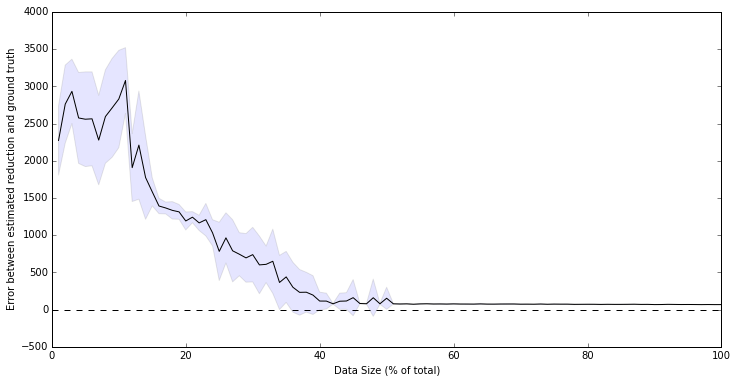

In [152]:
x = range(1,101)
y = np.array(errormeans)
d = np.array(errorstds)
plt.figure(figsize=(12,6))
plt.plot(x,y,color='k')
plt.fill_between(x,y-d,y+d,alpha=0.1)
plt.axhline(y=0,linestyle='--',color='k')
plt.xlabel('Data Size (% of total)')
plt.ylabel('Error between estimated reduction and ground truth')
plt.savefig("isomaperrors.png",format="png",dpi=480)